In [ ]:
#Author - Dustin Eagar
#January, 2024

## Fantasy Disc Golf Auction Valuation

The objective of this project is to use past results to create a draft auction valuation model for 2024 DGPT Fantasy Disc Golf.

## EDA of Past Results

In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc as pm 
import plotly.express as px

plt.style.use('ggplot')

pd.set_option('display.max_rows', None)

In [6]:
players_24 = pd.read_csv('./data/2024_pdga_tourcards_mpo.csv')
players_24

,Player,pdga_number
0,Aaron Gossage,35449
1,Adam Hammes,57365
2,Aidan Scott,99246
3,AJ Carey,61770
4,Albert Tamm,76669
...,...,...
88,Tuomas Hyytiäinen,65715
89,Ty Love,89959
90,Väinö Mäkelä,59635
91,Zach Arlinghaus,65266


## Scraping Data

In [184]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import time

In [20]:


url = 'https://www.pdga.com/tour/event/65208'#Music City Open
table_id = 'tournament-stats-0'

def scrape_pdga_table(url, table_id, event=False):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('table', id=table_id)
    rows = table.find_all('tr')

    # Extracting the header
    headers = []
    counter=1 #Counter for naming round rating columns
    for i, header in enumerate(rows[0].find_all('th')):
        header_text = header.text.strip()
        if event and not header_text:  # If the header is empty
            header_text = f'rating_{counter}'  # Assign a custom name
            counter+=1
        headers.append(header_text)

    # Extracting the data
    data = []
    for row in rows[1:]:
        cols = [ele.text.strip() for ele in row.find_all('td')]
        data.append(cols)

    # Creating the DataFrame
    df = pd.DataFrame(data, columns=headers)
    return df

# Displaying the DataFrame
#df = scrape_pdga_table(url, table_id, event=True)
df = 
df.head()


,Place,Points,Name,PDGA#,Rating,Par,Rd1,rating_1,Rd2,rating_2,Rd3,rating_3,Total,Prize
0,1,1160.00,Simon Lizotte,8332,1037,-23,59,1050,59,1046,54,1068,172,"$8,000"
1,2,1150.00,Anthony Barela,44382,1042,-22,59,1050,57,1059,57,1047,173,"$5,000"
2,3,1140.00,Calvin Heimburg,45971,1042,-21,61,1037,57,1059,56,1054,174,"$2,352"
3,3,1140.00,Gannon Buhr,75412,1041,-21,59,1050,58,1052,57,1047,174,"$2,352"
4,3,1140.00,Chris Dickerson,62467,1042,-21,59,1050,55,1072,60,1025,174,"$2,352"


In [185]:
def ratings_date_parse(s):
    parsed = s.split('to')[-1].strip(' ')

    return parsed

def scrape_player_stats(pdga_number, years_list):
    
    table_id_stats = "player-results-mpo"
    table_id_ratings = "player-results-details"
    
    stats = pd.DataFrame()
    for year in years_list:
        try:
            url_stats = f'https://www.pdga.com/player/{str(pdga_number)}/stats/{year}'
            stats_year = scrape_pdga_table(url=url_stats, table_id = table_id_stats)
            stats = pd.concat([stats, stats_year])
        except Exception as e:
            print(e)
            pass
        time.sleep(1.5)

    if stats.shape[0]>0:
        stats = stats[stats['Tier'].isin(['ES', 'M', 'A', 'B', 'XM'])]
        stats['Date'] = pd.to_datetime(stats['Dates'].apply(ratings_date_parse))

        stats = stats[['Place', 'Tier', 'Date', 'Tournament']]

    url_ratings = f'https://www.pdga.com/player/{str(pdga_number)}/details'
    
    
    try:
        ratings = scrape_pdga_table(url=url_ratings, table_id=table_id_ratings)
        ratings = ratings[ratings['Tier'].isin(['ES', 'M', 'A', 'B', 'XM'])]
        ratings['Date'] = pd.to_datetime(ratings['Date'].apply(ratings_date_parse))
        ratings = ratings[['Rating', 'Date', 'Tournament', 'Tier', 'Round']]
    except Exception as e:
        ratings=pd.DataFrame()
        print(f'{e}, {pdga_number}')
        pass


    return stats, ratings

stats, ratings = scrape_player_stats('76669', ['2020','2021','2022','2023'])
stats

,Place,Tier,Date,Tournament
1,4,A,2020-06-28,Prodigy Disc Pro Tour 2020 - Helsinki
2,10,A,2020-07-12,Prodigy Disc Pro Tour 2020 - Turku
4,1,A,2020-07-26,BDGC Alutaguse Open 2020 Sponsored by Innova C...
5,5,A,2020-08-02,Prodigy Disc Pro Tour - Kuopio
7,1,B,2020-08-28,Eesti Meistrivõistlused 2020
5,33,M,2021-06-26,2021 PDGA Professional Disc Golf World Champio...
6,9,A,2021-07-04,The Majestic
11,1,B,2021-08-28,Disctroyeri Eesti Meistrivõistlused discgolfis...
13,19,A,2021-10-03,Carolina Clash Presented by Another Round Disc...
14,42,XM,2021-10-09,United States Disc Golf Championship


In [186]:
ratings

,Rating,Date,Tournament,Tier,Round
2,1021,2023-10-08,United States Disc Golf Championship,XM,1
3,1032,2023-10-08,United States Disc Golf Championship,XM,2
4,993,2023-10-08,United States Disc Golf Championship,XM,3
5,1043,2023-10-08,United States Disc Golf Championship,XM,4
6,1045,2023-09-17,DGPT Playoffs - MVP Open presented by OTB,ES,1
...,...,...,...,...,...
410,946,2016-07-17,EuroTour #5 - Estonian Open,A,2
411,913,2016-07-17,EuroTour #5 - Estonian Open,A,3
416,967,2016-05-29,EuroTour #4 - HAIX Tali Open,A,1
417,967,2016-05-29,EuroTour #4 - HAIX Tali Open,A,2


In [48]:
#css selectors
css_selectors = {'career_events':'.career-events',
                 'join_date':'.join-date',
                 'rating_current':'.current-rating',
                 'career_events':'.career-events',
                 'career_wins':'.career-wins',
                 'career_earnings':'.career-earnings',
                 'world_rank':'.world-rank'}

#Get current rating and other stats
url = 'https://www.pdga.com/player/81739/details' #Casey White
response = requests.get(url)
collection_dict = {}
# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
for key, val in css_selectors.items():
    # Find element using CSS selector
    elements = soup.select(val)
    if elements:
        extracted_text = ' '.join([elem.get_text(strip=True) for elem in elements])
    else:
        extracted_text = 'Element not found'

    # Print or process the extracted text
    collection_dict[key]=extracted_text
    print(extracted_text.strip(f'{key}:{val}'))

collection_dict


Career Events:179
Member Since:2016
Current Rating:1018(as of 14-Nov-2023)
Career Wins:22
Career Earnings:$65,331.00
United States Tour Rank:#67


{'career_events': 'Career Events:179',
 'join_date': 'Member Since:2016',
 'rating_current': 'Current Rating:1018(as of 14-Nov-2023)',
 'career_wins': 'Career Wins:22',
 'career_earnings': 'Career Earnings:$65,331.00',
 'world_rank': 'United States Tour Rank:#67'}

In [50]:
def get_player_career_stats (player_pdga):

    #css selectors
    css_selectors = {'career_events_raw':'.career-events',
                 'join_date_raw':'.join-date',
                 'rating_current_raw':'.current-rating',
                 'career_events_raw':'.career-events',
                 'career_wins_raw':'.career-wins',
                 'career_earnings_raw':'.career-earnings',
                 'world_rank_raw':'.world-rank'}
    
    #Get current rating and other stats
    url = f'https://www.pdga.com/player/{str(player_pdga)}/details' #Casey White
    response = requests.get(url)

    # Parse the HTML content
    collection_dict = {'pdga_number':player_pdga}
    soup = BeautifulSoup(response.content, 'html.parser')
    for key, val in css_selectors.items():
        # Find element using CSS selector
        elements = soup.select(val)
        if elements:
            extracted_text = ' '.join([elem.get_text(strip=True) for elem in elements])
        else:
            extracted_text = 'Element not found'

        # Print or process the extracted text
        print(extracted_text.strip(f'{key}:{val}'))
        collection_dict[key]=extracted_text

    return collection_dict
    


#get_player_career_stats('81739')       

Career Events:179
Member Since:2016
Current Rating:1018(as of 14-Nov-2023)
Career Wins:22
Career Earnings:$65,331.00
United States Tour Rank:#67


{'pdga_number': '81739',
 'career_events_raw': 'Career Events:179',
 'join_date_raw': 'Member Since:2016',
 'rating_current_raw': 'Current Rating:1018(as of 14-Nov-2023)',
 'career_wins_raw': 'Career Wins:22',
 'career_earnings_raw': 'Career Earnings:$65,331.00',
 'world_rank_raw': 'United States Tour Rank:#67'}

In [112]:
def execute_player_stats_scrape():
    for index, row in tqdm(players_24.iterrows(), total=players_24.shape[0]):

        stats = get_player_career_stats(player_pdga=row['pdga_number'])

        for key, value in stats.items():
            players_24.at[index, key]=value

#players_24.to_csv('./data/players_basic_stats.csv')
players_24 = pd.read_csv('./data/players_basic_stats.csv', index_col=0)

In [113]:
players_24 = players_24[:-1]

In [121]:
import re
def extract_numbers(s):
    # Regular expression pattern
    pattern = r'.*[:$#]\s?((\d{1,5}(?:,\d{3})*|\d+)(\.\d+)?)'
    
    # Find all matches
    matches = re.findall(pattern, s)

    if matches:
        # Extracting only the numbers from the matches
        return [match[0] for match in matches][0]
    else:
        #Return none if no matches are found
        return None

In [115]:
players_24['career_events'] = players_24['career_events_raw'].apply(extract_numbers)
players_24['join_date'] = players_24['join_date_raw'].apply(extract_numbers)
players_24['rating_current'] = players_24['rating_current_raw'].apply(extract_numbers)
players_24['career_wins'] = players_24['career_wins_raw'].apply(extract_numbers)
players_24['career_earnings'] = players_24['career_earnings_raw'].apply(extract_numbers)
players_24['world_rank'] = players_24['world_rank_raw'].apply(extract_numbers)

players_24 = players_24.drop(columns=players_24.columns[2:8])

In [120]:
#players_24.to_csv('./data/players_basic_stats_processed.csv')

In [187]:
import time
def execute_player_stats_crawl():
    for index, row in tqdm(players_24.iterrows(), total=players_24.shape[0]):

        stats, ratings = scrape_player_stats(pdga_number=row['pdga_number'], years_list=['2022','2023'])

        players_24.at[index, 'stats_data'] = [stats.to_dict(orient='list')]
        players_24.at[index, 'ratings_data'] = [ratings.to_dict(orient='list')]
        time.sleep(1.5)

execute_player_stats_crawl()


  0%|          | 0/92 [00:00<?, ?it/s]

In [188]:
players_24.to_csv('./players_crawled.csv')

In [189]:
players_24

,Player,pdga_number,career_events,join_date,rating_current,career_wins,career_earnings,world_rank,stats_data,ratings_data
0,Aaron Gossage,35449,155,2008,1032,29,"114,142.00",29,"[{'Place': ['3', '57', '3', '5', '13', '50', '...","[{'Rating': ['1006', '968', '1034', '1034', '1..."
1,Adam Hammes,57365,188,2013,1028,28,"172,674.20",20,"[{'Place': ['1', '7', '4', '77', '13', '50', '...","[{'Rating': ['964', '1045', '1014', '1030', '9..."
2,Aidan Scott,99246,127,2017,1018,60,"28,136.00",46,"[{'Place': ['2', '1', '1', '1', '2', '6', '5',...","[{'Rating': ['984', '1017', '986', '1042', '98..."
3,AJ Carey,61770,290,2013,1012,21,"41,923.50",75,"[{'Place': ['39', '56', '52', '79', '34', '90'...","[{'Rating': ['1042', '993', '1042', '1044', '1..."
4,Albert Tamm,76669,153,2015,1022,25,"52,582.67",60,"[{'Place': ['34', '28', '66', '36', '1', '57',...","[{'Rating': ['1021', '1032', '993', '1043', '1..."
...,...,...,...,...,...,...,...,...,...,...
87,Tristan Tanner,99053,138,2017,1008,2,"34,187.25",62,"[{'Place': ['6', '86', '25', '60', '46', '112'...","[{'Rating': ['962', '968', '1026', '1041', '10..."
88,Tuomas Hyytiäinen,65715,164,2014,1017,17,"26,942.44",78,"[{'Place': ['97', '74', '58', '93', '58', '46'...","[{'Rating': ['1016', '1052', '1014', '1052', '..."
89,Ty Love,89959,72,2016,1012,6,"21,635.00",74,"[{'Place': ['5', '28', '26', '29', '14', '53',...","[{'Rating': ['993', '983', '1034', '1010', '10..."
90,Väinö Mäkelä,59635,158,2013,1030,22,"82,603.46",24,"[{'Place': ['45', '110', '51', '43', '3', '21'...","[{'Rating': ['1052', '986', '1034', '1045', '1..."


In [207]:
pd.DataFrame(players_24.iloc[0]['ratings_data'][0])

,Rating,Date,Tournament,Tier,Round
0,1006,2023-12-10,The Big Arm Challenge 4,B,1
1,968,2023-12-10,The Big Arm Challenge 4,B,2
2,1034,2023-11-19,Phoenix Fall Classic Presented by Dynamic Disc...,B,1
3,1034,2023-11-19,Phoenix Fall Classic Presented by Dynamic Disc...,B,2
4,1039,2023-10-29,Halloween Classic,B,1
...,...,...,...,...,...
286,756,2009-09-27,Johnny Roberts Memorial,B,2
287,837,2009-09-27,Johnny Roberts Memorial,B,3
288,737,2008-09-28,Colorado State Championships,A,1
289,799,2008-09-28,Colorado State Championships,A,2


In [222]:
def extract_ratings_vec(input_data, tiers:list=None, cutoff_date=None):
    '''
    Extract a filtered vector of round ratings from 
    a player's rating history object. Include round ratings
    in specified tiers and after cutoff date

    input_data - dictionary object of ratings scraped from
    ratings details. Read into dataframe
    tiers - list of strings
    cutoff_date - string date, 'yyyy-mm-dd', e.g. '2022-01-31'
    '''

    # column_dtypes = {'Rating':int,
    #                  'Date':pd.Timestamp,
    #                  'Tournament':str,
    #                  'Tier':str}
    
    df = pd.DataFrame(input_data)
    #df = df.astype(dtype=column_dtypes)

    #df['Rating'] = df['Rating'].astype(float)
    df['Date'] = pd.to_datetime(df['Date'])
    print(df.dtypes)
    if cutoff_date:
        cutoff = pd.Timestamp(cutoff_date)
        df = df[df['Date']>cutoff_date]

    if tiers:
        df = df[df['Tier'].isin(tiers)]
    ratings_vec = df['Rating'].values

    return ratings_vec

#Test
extract_ratings_vec(players_24.iloc[0]['ratings_data'][0],
                    tiers=['ES', 'M', 'XM', 'A'],
                    cutoff_date='2022-01-01')

Rating                object
Date          datetime64[ns]
Tournament            object
Tier                  object
Round                 object
dtype: object


array(['1005', '1012', '1018', '772', '1041', '1039', '1048', '1056',
       '1001', '1082', '1067', '1067', '1033', '1040', '1000', '1005',
       '1050', '1050', '1033', '1007', '1029', '1062', '999', '1037',
       '1006', '1016', '1023', '1036', '1011', '1033', '1030', '977',
       '1036', '1044', '1021', '1031', '1075', '1017', '1002', '1024',
       '1038', '1022', '1035', '1047', '1020', '1034', '1062', '1048',
       '1032', '1060', '1057', '1030', '1043', '1052', '1059', '1006',
       '1055', '1054', '1054', '1063', '1008', '1030', '999', '1019',
       '1006', '1019', '1031', '1026', '1047', '1027', '1041', '1064',
       '1030', '1045', '1021', '1015', '1028', '1015', '1065', '1075',
       '1053', '1053', '1006', '1079', '1003', '1031', '1018', '1036',
       '981', '1054', '1054', '1026', '1008', '1018', '965', '1027',
       '1018', '1039', '973', '1033', '1074', '1017', '982', '1063',
       '1064', '1063', '1057', '1044', '1018', '1012', '996', '1018',
       '1017', 

In [223]:
#Need to fix this
players_24['ratings_data'].apply(extract_ratings_vec)

TypeError: <class 'list'> is not convertible to datetime

In [246]:
pd.DataFrame(players_24['stats_data'].values[0][0]).dtypes

Place                 object
Tier                  object
Date          datetime64[ns]
Tournament            object
dtype: object

In [262]:
points_map = {
    1:300,
    2:245,
    3:195,
    4:155,
    5:135,
    6:110,
    7:97,
    8:85,
    9:75,
    10:64,
    11:56,
    12:48,
    13:42,
    14:36,
    15:33,
    16:30,
    17:24,
    18:24,
    19:21,
    20:18,
    21:15,
    22:12,
    23:10,
    24:8,
    25:6,
    26:4,
    27:3,
    28:2,
    29:1,   
}

def calculate_points(input_obj, points_map, year):

    df = pd.DataFrame(input_obj[0])
    df = df[df['Tier'].isin(['M', 'ES', 'XM'])]
    df = df[df['Date'].dt.year == year]
    print(len(df))

    df['event_points'] = df['Place'].astype(int).map(points_map)
    df.loc[df['Tier'].isin(['M', 'XM']), 'event_points']*=1.5

    total_points = df['event_points'].sum()

    return total_points


In [263]:
players_24['fantasy_points_23'] = players_24['stats_data'].apply(
    lambda x : calculate_points(x, points_map = points_map, year=2023))

players_24['fantasy_points_22'] = players_24['stats_data'].apply(
    lambda x : calculate_points(x, points_map = points_map, year=2022))

20
20
8
15
16
19
16
14
18
19
16
12
18
18
4
19
20
8
15
15
18
18
16
16
18
13
17
11
17
7
16
18
19
16
11
19
17
18
17
19
16
8
14
19
17
16
17
12
19
19
18
3
15
9
7
19
12
18
4
7
19
19
9
16
12
14
17
8
10
12
18
12
18
2
9
12
20
13
15
15
19
13
5
16
11
15
11
19
11
11
13
16
18
18
0
18
18
18
10
16
15
14
18
10
15
18
0
19
18
4
16
17
17
18
15
12
14
17
17
1
18
15
5
16
15
12
7
19
6
18
17
17
10
2
15
13
11
7
2
7
18
12
19
2
16
2
2
18
14
18
9
17
17
17
3
17
1
14
13
3
10
7
9
11
4
2
18
9
13
13
7
18
8
10
12
17
6
17
11
17
9
6
12
6


In [264]:
players_24['rating_current'] = players_24['rating_current'].astype(float)

In [265]:
px.scatter(players_24, x='rating_current', y='fantasy_points_23', hover_name='Player')

In [269]:
players_24['rating_current'].corr(players_24['fantasy_points_23'])

0.7774410361931111

<AxesSubplot: xlabel='fantasy_points_23', ylabel='Count'>

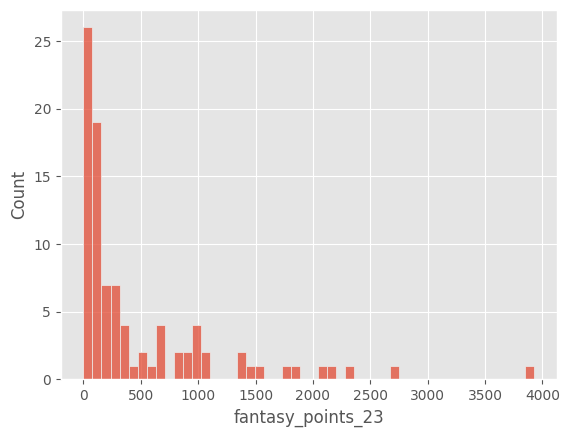

In [266]:
sns.histplot(players_24['fantasy_points_23'], bins=50)

In [267]:
px.scatter(players_24, x='fantasy_points_22', y='fantasy_points_23', hover_name='Player')

In [287]:
#weighted average of 22 and 23 fantasy points
from scipy import stats
import numpy as np

players_24['composite_fp'] = .65*players_24['fantasy_points_23'] + .35*players_24['fantasy_points_22']
players_24['composite_percentile'] = players_24['composite_fp'].apply(lambda x : np.round(stats.percentileofscore(players_24['composite_fp'], x), 1))
players_24['frac_calvin'] = players_24['composite_fp']/3464

<AxesSubplot: xlabel='composite_fp', ylabel='Count'>

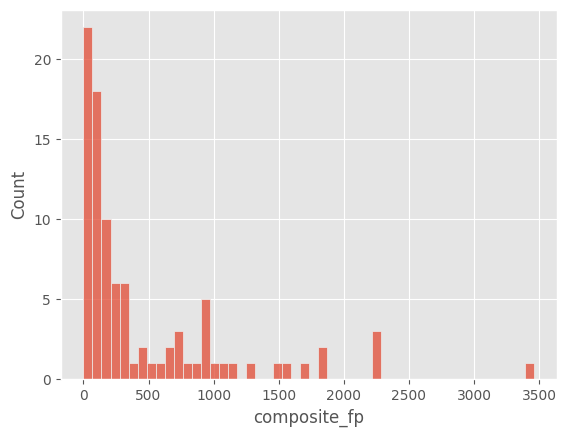

In [274]:
sns.histplot(players_24['composite_fp'], bins=50)

In [288]:
draft = players_24.drop(columns=['stats_data', 'ratings_data', 'career_earnings', 'world_rank', 'pdga_number']).sort_values(by='composite_fp', ascending=False)
draft.reset_index(drop=True)

,Player,career_events,join_date,rating_current,career_wins,fantasy_points_23,fantasy_points_22,composite_fp,composite_percentile,frac_calvin
0,Calvin Heimburg,260,2010,1052.0,56,3929.5,2599.5,3464.000,100.0,1.000000
1,Ricky Wysocki,401,2009,1047.0,128,1849.0,3093.0,2284.400,98.9,0.659469
2,Gannon Buhr,None,None,NaN,None,2104.0,2539.5,2256.425,97.8,0.651393
3,Isaac Robinson,156,2011,1041.0,34,2686.5,1401.5,2236.750,96.7,0.645713
4,Simon Lizotte,260,2005,1044.0,80,1730.5,2019.0,1831.475,95.7,0.528717
5,Kyle Klein,None,None,NaN,None,2148.5,1223.0,1824.575,94.6,0.526725
6,Eagle McMahon,222,2008,1049.0,56,2282.0,519.0,1664.950,93.5,0.480644
7,Matt Orum,None,None,NaN,None,1554.5,1618.5,1576.900,92.4,0.455225
8,Paul McBeth,410,2005,1049.0,149,645.0,2990.5,1465.925,91.3,0.423189
9,Chris Dickerson,None,None,NaN,None,944.0,1817.0,1249.550,90.2,0.360725
